In [0]:
# Thư viện
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Thông số ban đầu
table_input = "vaccine_order_sampled"
table_region = "dim_shop"                   
table_output = "vaccine_cluster_result"   

random_state = 42     


In [0]:
# Đọc dữ liệu gốc
df_orders = spark.table(table_input)
df_region = spark.table(table_region)

print("Dữ liệu đầu vào:")
display(df_orders.limit(5))
print("Dữ liệu thông tin vùng:")
display(df_region.limit(5))

# **Khám phá - Phân tích dữ liệu**

In [0]:
# Cấu hình cho biểu đồ 
sns.set(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Hàm EDA
def perform_eda(df_orders, df_region):
    """
    Thực hiện phân tích dữ liệu khám phá (EDA) toàn diện.

    Args:
        df_orders (Spark DataFrame): DataFrame chứa dữ liệu giao dịch.
        df_region (Spark DataFrame): DataFrame chứa thông tin vùng.
    """
    print("Bắt đầu quá trình Khám phá Dữ liệu (EDA)")

    # --- 1. Thống kê tổng quan ---
    print("\n1. Thống kê tổng quan về bộ dữ liệu")
    summary_stats = df_orders.select(
        F.countDistinct("order_code").alias("distinct_orders"),
        F.countDistinct("shop_code").alias("distinct_shops"),
        F.count("order_code").alias("total_line_items")
    ).collect()[0]

    print(f"- Tổng số dòng dữ liệu (line items): {summary_stats['total_line_items']:,}")
    print(f"- Tổng số đơn hàng duy nhất: {summary_stats['distinct_orders']:,}")
    print(f"- Tổng số trung tâm tiêm chủng: {summary_stats['distinct_shops']:,}")

    # --- 2. Phân tích các biến số ---
    print("\n2. Phân tích các biến số chính")
    
    # Chuyển các cột cần phân tích sang Pandas để vẽ biểu đồ
    pdf_numerical = df_orders.select(
        "line_item_quantity", 
        "line_item_amount_after_discount"
    ).toPandas()

    # a. Phân bổ của Giá trị sản phẩm (Amount)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(pdf_numerical['line_item_amount_after_discount'], kde=True, bins=50)
    plt.title('Phân bổ Giá trị Sản phẩm (sau giảm giá)')
    plt.xlabel('Giá trị (VNĐ)')
    plt.ylabel('Tần suất')

    # b. Phân bổ của Số lượng sản phẩm (Quantity)
    plt.subplot(1, 2, 2)
    sns.countplot(x='line_item_quantity', data=pdf_numerical, order=pdf_numerical['line_item_quantity'].value_counts().index)
    plt.title('Phân bổ Số lượng Sản phẩm trên mỗi dòng')
    plt.xlabel('Số lượng')
    plt.ylabel('Số lượng dòng')
    plt.tight_layout()
    plt.show()

    print("Thống kê mô tả cho giá trị sản phẩm:")
    display(pdf_numerical['line_item_amount_after_discount'].describe().apply("{:,.2f}".format))

    # --- 3. Phân tích các biến hạng mục (theo Vùng miền) ---
    print("\n3. Phân tích theo Vùng miền")
    
    # Join hai bảng và tính số đơn hàng theo vùng
    df_orders_by_region = df_orders.join(df_region, on="shop_code", how="inner") \
                                   .groupBy("region_name") \
                                   .agg(F.countDistinct("order_code").alias("num_orders")) \
                                   .orderBy("num_orders", ascending=False)
    
    pdf_region = df_orders_by_region.toPandas()
    
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x='num_orders', y='region_name', data=pdf_region, palette='plasma')
    plt.title('Tổng số đơn hàng theo Vùng miền')
    plt.xlabel('Số lượng đơn hàng')
    plt.ylabel('Vùng miền')
    # Thêm nhãn số lượng trên các thanh bar
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 50, p.get_y() + p.get_height()/2, f'{int(width):,}', va='center')
    plt.show()

    print("\nQuá trình EDA hoàn tất.")

Bắt đầu quá trình Khám phá Dữ liệu (EDA)

1. Thống kê tổng quan về bộ dữ liệu
- Tổng số dòng dữ liệu (line items): 16,111
- Tổng số đơn hàng duy nhất: 9,000
- Tổng số trung tâm tiêm chủng: 200

2. Phân tích các biến số chính


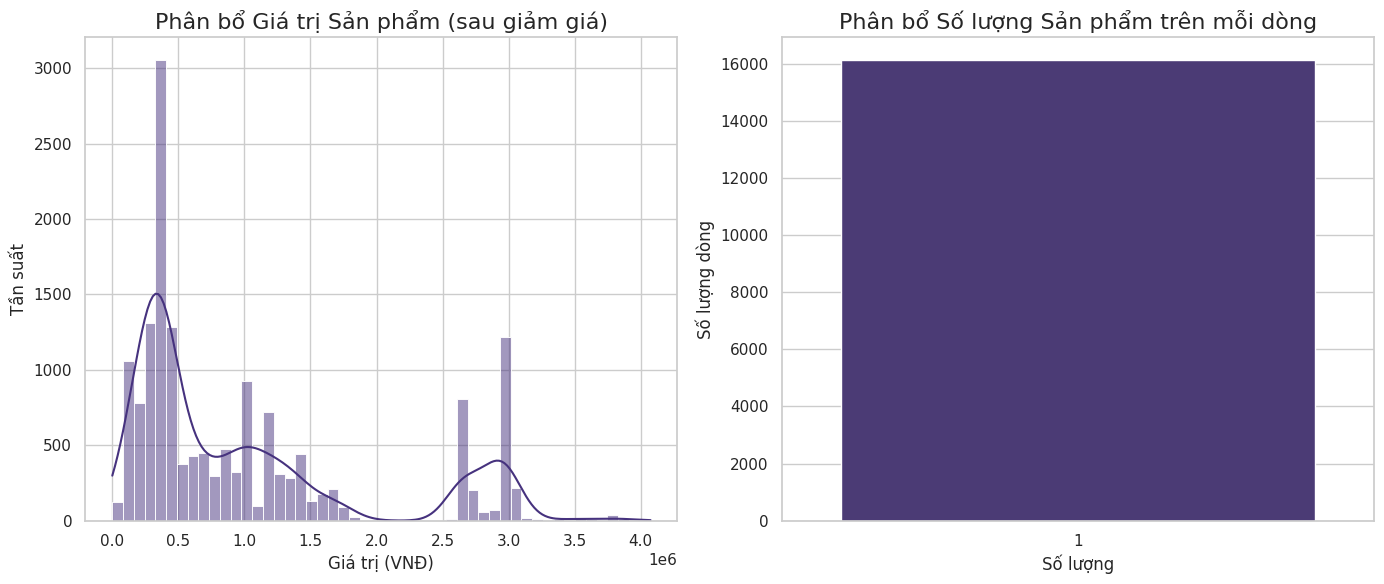

Thống kê mô tả cho giá trị sản phẩm:


count       16,111.00
mean     1,005,925.35
std        935,611.25
min              0.00
25%        333,000.00
50%        588,000.00
75%      1,319,200.00
max      4,074,000.00
Name: line_item_amount_after_discount, dtype: object


3. Phân tích theo Vùng miền


/home/spark-e6d36101-74d0-4de0-9e96-f9/.ipykernel/2400/command-8463533776668075-1481248933:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='num_orders', y='region_name', data=pdf_region, palette='plasma')


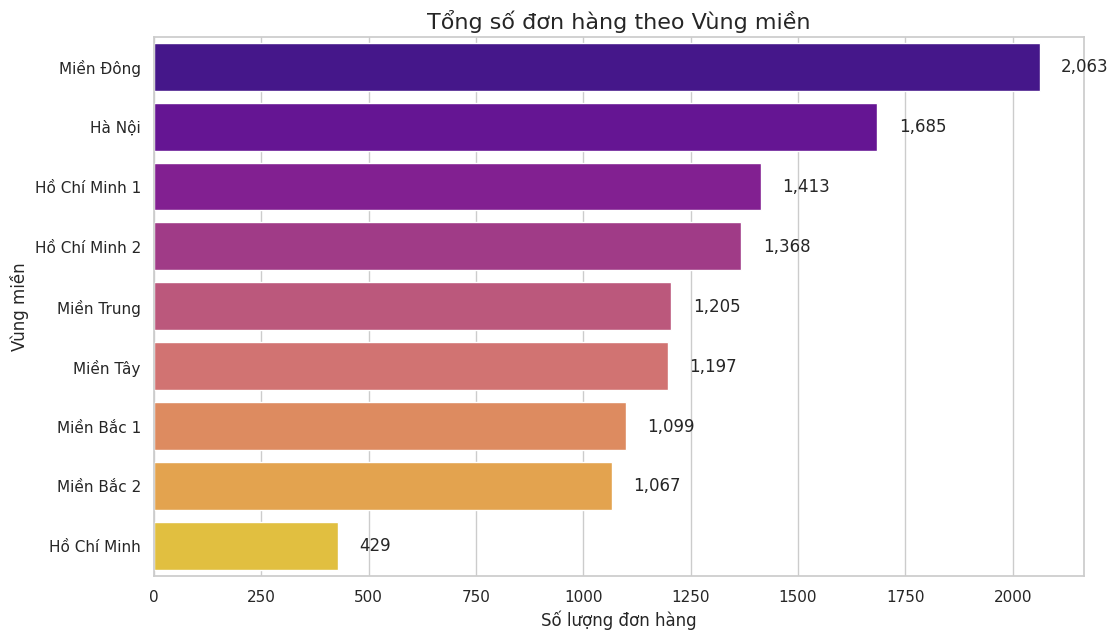


Quá trình EDA hoàn tất.


In [0]:
# Gọi hàm EDA
perform_eda(df_orders, df_region)

# **Phân cụm**

## _Tiền xử lí dữ liệu_

In [0]:
# Tổng hợp dữ liệu theo cấp đơn hàng
df_order_level = (
    df_orders.groupBy("order_code", "shop_code", "month")
    .agg(
        F.sum("line_item_quantity").alias("num_items"),
        F.sum("line_item_amount_after_discount").alias("total_amount"),
        F.countDistinct("sku").alias("num_unique_products"),
        F.sum(F.when(F.col("line_item_discount_promotion") > 0, 1).otherwise(0)).alias("promotion_flag")
    )
)

print("Dữ liệu sau khi tổng hợp theo đơn hàng:")
display(df_order_level.limit(5))

Dữ liệu sau khi tổng hợp theo đơn hàng:


order_code,shop_code,month,num_items,total_amount,num_unique_products,promotion_flag
58075671691750814639657,58075,2025-06,1,850000.0,1,0
58046269671750643336650,58046,2025-06,2,1475000.0,2,0
58074926881744433131022,58074,2025-04,3,8526000.0,1,3
58064936431750935056359,58064,2025-06,2,1704610.0,2,2
58079681181749261909009,58079,2025-06,4,2581710.0,3,4


In [0]:
# Gắn thông tin vùng địa lí
df_joined = df_order_level.join(
    df_region.select("shop_code", "region_name"),
    on="shop_code",
    how="left"
)

print("Dữ liệu sau khi thêm vùng địa lí:")
display(df_joined.limit(5))

Dữ liệu sau khi thêm vùng địa lí:


shop_code,order_code,month,num_items,total_amount,num_unique_products,promotion_flag,region_name
58075,58075671691750814639657,2025-06,1,850000.0,1,0,Miền Bắc 2
58046,58046269671750643336650,2025-06,2,1475000.0,2,0,Hồ Chí Minh 1
58074,58074926881744433131022,2025-04,3,8526000.0,1,3,Miền Trung
58064,58064936431750935056359,2025-06,2,1704610.0,2,2,Miền Tây
58079,58079681181749261909009,2025-06,4,2581710.0,3,4,Hà Nội


In [0]:
pdf = df_joined.toPandas()
pdf = pdf.drop(columns=["shop_code", "order_code"], errors="ignore")
pdf["total_amount_log"] = np.log1p(pdf["total_amount"])  

# Danh sách các biến
numeric_features = ["num_items", "total_amount_log", "num_unique_products", "promotion_flag"]
categorical_features = ["region_name"]

# Chuẩn hóa và mã hóa
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])
X_prepared = preprocessor.fit_transform(pdf)

Text(0, 0.5, 'Tần suất')

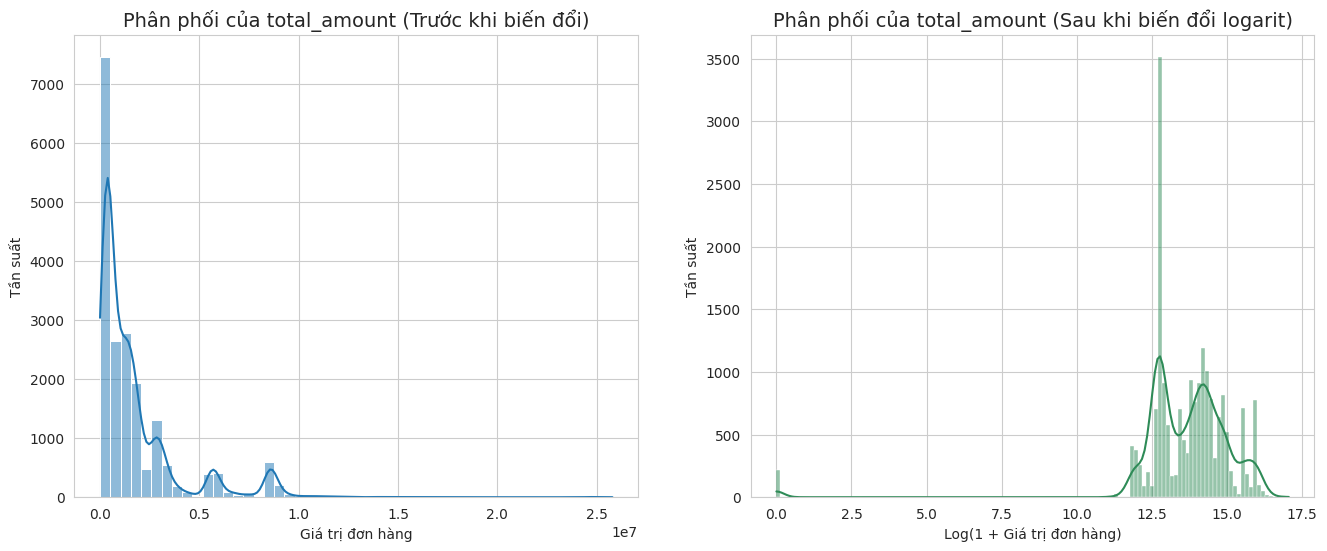

In [0]:
# Thiết lập biểu đồ phân phối của total_amount

# Thiết lập style cho biểu đồ
sns.set_style("whitegrid")

# Tạo một figure chứa hai biểu đồ con đặt cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Phân phối của total_amount gốc
sns.histplot(pdf['total_amount'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Phân phối của total_amount (Trước khi biến đổi)', fontsize=14)
axes[0].set_xlabel('Giá trị đơn hàng')
axes[0].set_ylabel('Tần suất')

# Phân phối của total_amount sau khi biến đổi logarit
sns.histplot(pdf['total_amount_log'], kde=True, ax=axes[1], color='seagreen')
axes[1].set_title('Phân phối của total_amount (Sau khi biến đổi logarit)', fontsize=14)
axes[1].set_xlabel('Log(1 + Giá trị đơn hàng)')
axes[1].set_ylabel('Tần suất')

## _Thực hiện phân cụm với K-Means_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7facb8e659e0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

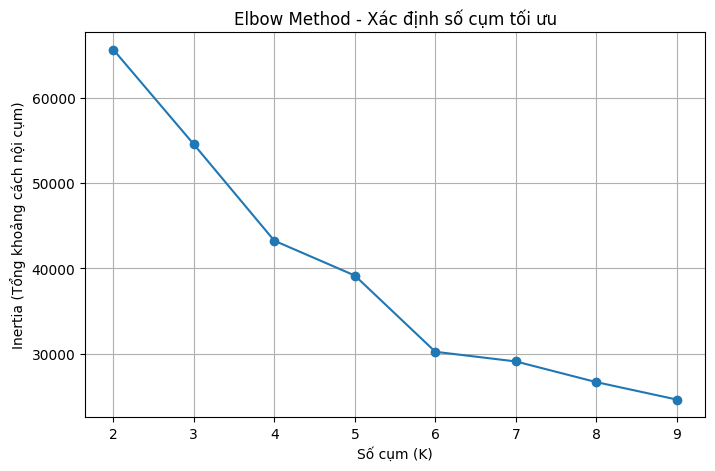

In [0]:
# Xác định số lượng cụm tối ưu
inertia = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=random_state)
    km.fit(X_prepared)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method - Xác định số cụm tối ưu")
plt.xlabel("Số cụm (K)")
plt.ylabel("Inertia (Tổng khoảng cách nội cụm)")
plt.grid(True)
plt.show()

In [0]:
# Phân cụm bằng K-Means
optimal_k = 6  
kmeans = KMeans(n_clusters=optimal_k, random_state=random_state)
kmeans.fit(X_prepared)
pdf["cluster"] = kmeans.labels_

print("Đã phân cụm xong. Số cụm:", optimal_k)
pdf.head()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faca8f182c0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Đã phân cụm xong. Số cụm: 6


,month,num_items,total_amount,num_unique_products,promotion_flag,region_name,total_amount_log,cluster
0,2025-06,1,850000.0,1,0,Miền Bắc 2,13.652993,0
1,2025-06,2,1475000.0,2,0,Hồ Chí Minh 1,14.204169,4
2,2025-04,3,8526000.0,1,3,Miền Trung,15.958631,2
3,2025-06,2,1704610.0,2,2,Miền Tây,14.348847,4
4,2025-06,4,2581710.0,3,4,Hà Nội,14.763963,1


### _Kết quả phân cụm_

Số cụm (K): 6
Silhouette Score: 0.3393


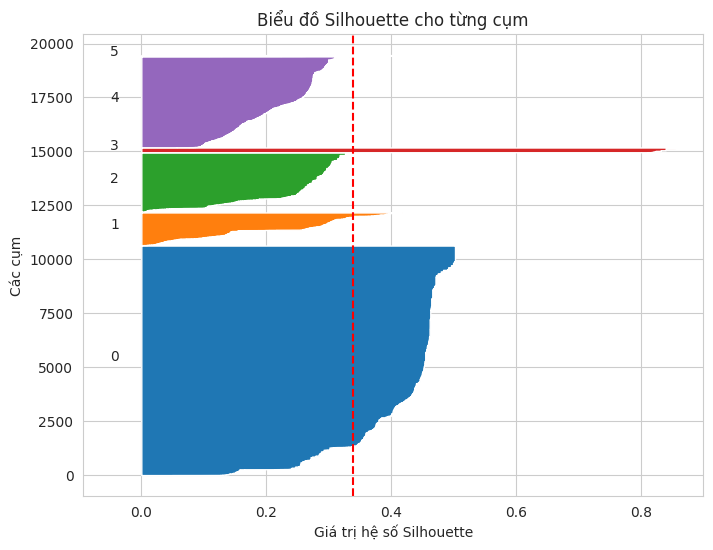

In [0]:
# Dữ liệu đầu vào đã được chuẩn hóa và mô hình K-Means đã huấn luyện trước đó
labels = kmeans.labels_

# Tính chỉ số đánh giá
sil_score = silhouette_score(X_prepared, labels)

# Hiển thị kết quả đánh giá
print("=== ĐÁNH GIÁ MÔ HÌNH PHÂN CỤM K-MEANS ===")
print(f"Số cụm (K): {optimal_k}")
print(f"Silhouette Score: {sil_score:.4f}")

# So sánh Silhouette theo từng cụm
sample_silhouette_values = silhouette_samples(X_prepared, labels)
y_lower = 10
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # khoảng cách giữa các cụm

plt.title("Biểu đồ Silhouette cho từng cụm")
plt.xlabel("Giá trị hệ số Silhouette")
plt.ylabel("Các cụm")
plt.axvline(x=sil_score, color="red", linestyle="--")
plt.show()


In [0]:
# Phân tích kết quả phân cụm

# Tìm đặc trưng trung bình của từng cụm
cluster_summary = (
    pdf.groupby("cluster")[["num_items", "total_amount", "num_unique_products", "promotion_flag"]]
    .mean()
    .round(2)
    .reset_index()
)

print("Đặc trưng trung bình của từng cụm:")
display(cluster_summary)

Đặc trưng trung bình của từng cụm:


cluster,num_items,total_amount,num_unique_products,promotion_flag
0,1.0,725917.63,1.0,0.12
1,4.31,4199357.7,2.81,4.28
2,2.46,4009606.85,1.0,2.46
3,1.0,0.0,1.0,1.0
4,2.23,1962621.58,2.03,1.53
5,16.65,1.345340333E7,7.96,16.41


Phân bố cụm theo khu vực:


region_name,cluster,count
Hà Nội,0,1170
Hà Nội,1,209
Hà Nội,2,386
Hà Nội,3,54
Hà Nội,4,557
Hà Nội,5,9
Hồ Chí Minh,0,323
Hồ Chí Minh,1,28
Hồ Chí Minh,2,86
Hồ Chí Minh,3,3


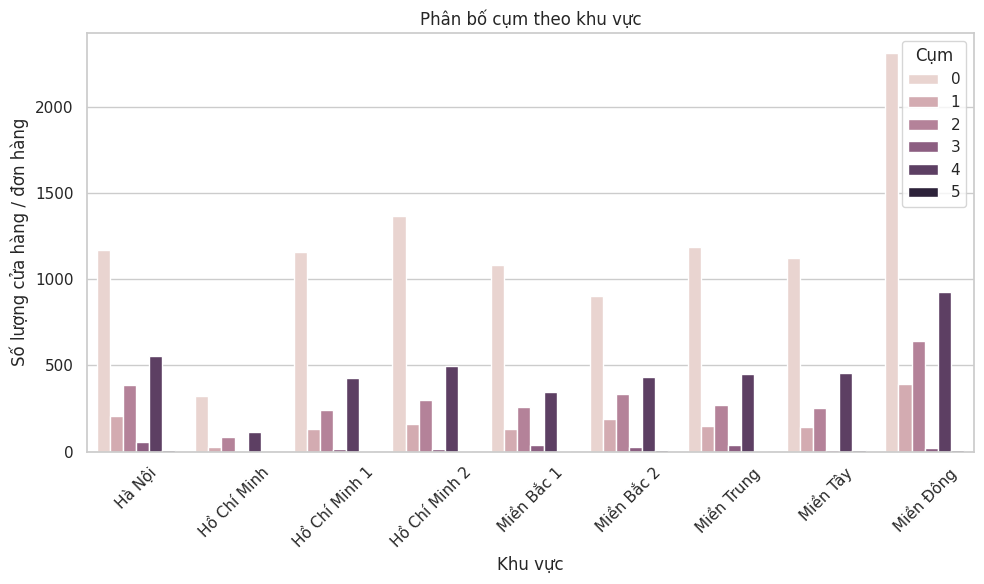

In [0]:
# Phân tích phân bố cụm theo khu vực

# Thống kê số lượng cửa hàng thuộc từng cụm trong mỗi khu vực
cluster_summary = (
    pdf.groupby(["region_name", "cluster"])
       .size()
       .reset_index(name="count")
       .sort_values(["region_name", "cluster"])
)

print("Phân bố cụm theo khu vực:")
display(cluster_summary)

# Vẽ biểu đồ trực quan hóa phân bố
plt.figure(figsize=(10,6))
sns.barplot(data=cluster_summary, x="region_name", y="count", hue="cluster")
plt.title("Phân bố cụm theo khu vực")
plt.xlabel("Khu vực")
plt.ylabel("Số lượng cửa hàng / đơn hàng")
plt.legend(title="Cụm")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
# Đánh giá chất lượng phân cụm
silhouette = silhouette_score(X_prepared, pdf["cluster"])
print(f"Silhouette Score: {silhouette:.4f}")